In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from mmon_gcm.analysing import get_phase_lengths
from mmon_gcm.supermodel import SuperModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme()
sns.set_style("ticks")
palettes = {
    "tol_bright": sns.color_palette(
        ["#4477AA", "#66CCEE", "#228833", "#CCBB44", "#EE6677", "#AA3377", "#BBBBBB"]
    ),
    "tol_muted": sns.color_palette(
        [
            "#332288",
            "#88CCEE",
            "#44AA99",
            "#117733",
            "#999933",
            "#DDCC77",
            "#CC6677",
            "#882255",
            "#AA4499",
        ]
    ),
}
sns.set_palette(palettes["tol_muted"])

colours = sns.color_palette()

params = {
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
    "axes.labelsize": "large",
    "axes.titlesize": "x-large",
    "font.family": "sans-serif",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "lines.linewidth": 2.5,
    "figure.figsize": [5, 3.75],
    "figure.dpi": 150,
}
plt.rcParams.update(params)

In [4]:
def get_bounds_in_model(constraints):
    super_model = SuperModel(constraints)
    volumes = super_model.get_volumes(per_guard_cell=False)
    closed_volume = volumes[0]
    open_volume = volumes[1]
    osmolarities = super_model.get_osmolarities()
    closed_osmolarity = osmolarities[0]
    open_osmolarity = osmolarities[1]
    photons = super_model.get_photons(150)
    gc_photons = photons[0]
    gc_atpase_upper_bound = super_model.get_atpase_constraint_value(
        constraints.loc["ATPase"]
    )

    return {
        "V_closed": closed_volume,
        "V_open": open_volume,
        "Os_closed": closed_osmolarity,
        "Os_open": open_osmolarity,
        "Photons": gc_photons,
        "ATPase": gc_atpase_upper_bound,
    }

# Analysing the results of the constraint scan

## Importing results and constraints

In [5]:
# import results files
blue_results = pd.read_csv(
    "../outputs/constraint_scan/constraint_scan_results_blue.csv", index_col=0
)
white_results = pd.read_csv(
    "../outputs/constraint_scan/constraint_scan_results_white.csv", index_col=0
)
scan_results = pd.concat([white_results, blue_results])
scan_results = scan_results.reset_index().drop("index", axis=1)
# remove solutions which were not feasible
infeasible_solutions = scan_results[scan_results.isna().any(axis=1)]
feasible_solutions = scan_results.dropna()
scan_results = feasible_solutions

In [6]:
len(infeasible_solutions)

2

In [7]:
len(feasible_solutions)

1934

In [8]:
scan_results.shape

(1934, 7101)

In [9]:
# convert any fluxes that are below 10^-6 to 0
scan_results = scan_results.mask(abs(scan_results) < 0.000001, other=0)

In [10]:
# import constraints files
white_constraints = pd.read_csv(
    "../outputs/constraint_scan/constraints_df.csv", index_col=0
)
white_constraints["light"] = "white"
blue_constraints = pd.read_csv(
    "../outputs/constraint_scan/constraints_df.csv", index_col=0
)
blue_constraints["light"] = "blue"
scan_constraints = pd.concat([white_constraints, blue_constraints])
scan_constraints = scan_constraints.reset_index().drop("index", axis=1)
# remove infeasible constraints combinations
feasible_scan_constraints = scan_constraints.loc[feasible_solutions.index]
infeasible_scan_constraints = scan_constraints.loc[infeasible_solutions.index]
scan_constraints = feasible_scan_constraints

# Remove maintenance in scan_constraints
#scan_constraints = scan_constraints.drop('Maintenance', axis=1)

In [11]:
scan_constraints.columns

Index(['P_abs', 'T_l', 'A_l', 'V_gc_ind', 'FqFm', 'R_ch', 'R_ch_vol', 'L_air',
       'L_epidermis', 'Vac_frac', 'T', 'R', 'N_gcs', 'n', 'm', 'r', 's',
       'C_apo', 'A_closed', 'A_open', 'ATPase', 'light'],
      dtype='object')

In [12]:
# import constraints that were used in previous paper solutions
default_constraints = pd.read_csv("../inputs/arabidopsis_parameters.csv", index_col=0)[
    "Value"
]

paper_constraints = []
index = []
for light in ["white", "blue", "nops"]:
    for constraint in ["unconstrained", "constrained"]:
        constraints = default_constraints.copy()
        if constraint == "unconstrained":
            constraints["ATPase"] = 1000
        elif constraint == "constrained":
            constraints["ATPase"] = 7.48
        constraints["light"] = light
        index.append(f"{light}_{constraint}_wt")
        paper_constraints.append(constraints)
paper_constraints = pd.DataFrame(paper_constraints, index=index)
paper_constraints = paper_constraints.iloc[1, :-1]
paper_constraints

P_abs                  0.9
T_l                0.00017
A_l                    1.0
V_gc_ind               0.0
FqFm                   0.9
R_ch              0.069231
R_ch_vol          0.200476
L_air                 0.37
L_epidermis           0.15
Vac_frac             0.751
T                   296.15
R                  0.08205
N_gcs          580000000.0
n                      2.5
m                      0.8
r                      0.0
s                      0.0
C_apo              0.02302
A_closed               1.6
A_open                2.75
ATPase                7.48
Name: white_constrained_wt, dtype: object

In [13]:
# import results for previous simulations in paper
paper_solution_files = []

for light in ["white", "blue", "nops"]:
    for constraint in ["unconstrained", "constrained"]:
        paper_solution_files.append(f"{light}_{constraint}_wt.csv")
solution_dfs = [
    pd.read_csv(f"../outputs/model_solutions/{file_name}", index_col=0)["fluxes"]
    for file_name in paper_solution_files
]
paper_results = pd.concat(solution_dfs, axis=1).T
paper_results.index = index

In [14]:
# get a reduced get of constraints that are more specific to the guard cell

scan_gc_constraints = pd.DataFrame.from_dict(
    list(scan_constraints.apply(get_bounds_in_model, axis=1))
)
scan_gc_constraints["Os_dif"] = (
    scan_gc_constraints["Os_open"] - scan_gc_constraints["Os_closed"]
)
scan_gc_constraints.index = scan_constraints.index
scan_gc_constraints.head()

/home/maurice/Sync/GC/mmon-gcm/mmon_gcm/supermodel.py:23: UserWarning: No fba model added to the Supermodel, fine if that's what you want
  warnings.warn("No fba model added to the Supermodel, fine if that's what you want")


,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
0,0.000157,0.000476,0.033212,0.278138,0.107908,0.004851,0.244926
1,0.000321,0.000738,0.067499,0.370715,0.106820,0.000585,0.303216
2,0.000248,0.000268,0.059662,0.070491,0.031490,0.004505,0.010828
3,0.000134,0.000278,0.033181,0.140030,0.013079,0.004855,0.106849
4,0.000438,0.000786,0.107888,0.313097,0.034626,0.011479,0.205209


In [15]:
paper_gc_constraints = pd.Series(get_bounds_in_model(paper_constraints))
paper_gc_constraints["Os_dif"] = (
    paper_gc_constraints["Os_open"] - paper_gc_constraints["Os_closed"]
)
paper_gc_constraints

/home/maurice/Sync/GC/mmon-gcm/mmon_gcm/supermodel.py:23: UserWarning: No fba model added to the Supermodel, fine if that's what you want
  warnings.warn("No fba model added to the Supermodel, fine if that's what you want")


V_closed     0.000220
V_open       0.000254
Os_closed    0.039359
Os_open      0.054922
Photons      0.018372
ATPase       0.004338
Os_dif       0.015563
dtype: float64

## 7a - What contributes to phloem output?

### Set up features for linear regression by 

#### Convert light using onehotencoder

In [16]:
scan_constraints[["light"]]

,light
0,white
1,white
2,white
3,white
4,white
...,...
1931,blue
1932,blue
1933,blue
1934,blue


In [17]:
# extract the subject column as a pandas DataFrame
light = scan_constraints[["light"]]
# setting sparse=False means that enc.transform() will return an array
enc = OneHotEncoder(sparse_output=False)

# fit the encoder to the data
enc.fit(light)

# encode the data
light_enc = enc.transform(light)
light_columns = pd.DataFrame(light_enc, columns="light_" + enc.categories_[0], index=scan_constraints.index) # Added index=scan_constraints.index 
full_features = scan_constraints.drop("light", axis=1).join(light_columns)
gc_features = scan_gc_constraints.join(light_columns)

#### Also create scaled versions of features

In [18]:
scaler = StandardScaler()

scaler.fit(full_features)
full_features_scaled = scaler.transform(full_features)

scaler.fit(gc_features)
gc_features_scaled = scaler.transform(gc_features)

In [19]:
full_features[full_features.isna().any(axis=1)]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,n,m,r,s,C_apo,A_closed,A_open,ATPase,light_blue,light_white


### Compare full and gc features

In [20]:
response = scan_results.Phloem_tx_overall
#response = scan_results.Photon_tx_gc_3

lm_full = LinearRegression()
lm_full.fit(full_features, response)
full_pred = lm_full.predict(full_features)
print("Mean squared error, MSE = %.5f" % mean_squared_error(response, full_pred))
print("Coefficient of determination, r2 = %.5f" % r2_score(response, full_pred))

lm_gc = LinearRegression()
lm_gc.fit(gc_features, response)
gc_pred = lm_gc.predict(gc_features)
print("Mean squared error, MSE = %.5f" % mean_squared_error(response, gc_pred))
print("Coefficient of determination, r2 = %.5f" % r2_score(response, gc_pred))

Mean squared error, MSE = 0.00040
Coefficient of determination, r2 = 0.99960
Mean squared error, MSE = 0.87829
Coefficient of determination, r2 = 0.12388


So can't predict phloem output using GC features, but can predict pretty well using the full set

#### Which features are most important?

In [21]:
pd.DataFrame(lm_full.coef_, index=full_features.columns).sort_values(by=0)

,0
T_l,-4.514050e-01
light_blue,-3.533915e-01
C_apo,-1.320172e-03
m,-8.770751e-04
Vac_frac,-7.229537e-04
A_open,-2.302990e-04
FqFm,-6.018903e-05
n,-5.320860e-05
V_gc_ind,-9.982424e-10
r,-6.477489e-12


Lots of unimportant features so we can use lasso regression to see which ones we really need

#### Try different alphas for lasso to see r2

In [22]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.01, 0.1, 10)
r2s = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_features, response)
    lasso_pred = lasso.predict(full_features)
    r2s.append(r2_score(response, lasso_pred))

pd.Series(r2s, index=alphas)

0.01    0.962288
0.02    0.850360
0.03    0.663812
0.04    0.402646
0.05    0.116440
0.06    0.111850
0.07    0.106593
0.08    0.100528
0.09    0.093654
0.10    0.085972
dtype: float64

In [23]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.001, 0.01, 10)
r2s = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_features, response)
    lasso_pred = lasso.predict(full_features)
    r2s.append(r2_score(response, lasso_pred))

pd.Series(r2s, index=alphas)

0.001    0.999224
0.002    0.998105
0.003    0.996240
0.004    0.993628
0.005    0.990270
0.006    0.986166
0.007    0.981316
0.008    0.975719
0.009    0.969377
0.010    0.962288
dtype: float64

Lets take 0.03 as it's highest that rounds to 0.999

#### Lasso with alpha = 0.003

In [24]:
lasso = Lasso(alpha=0.003)
lasso.fit(full_features, response)
lasso_pred = lasso.predict(full_features)
lass_coefs = pd.DataFrame(lasso.coef_, index=full_features.columns).sort_values(by=0)
# display coefficients that aren't 0
lass_coefs[abs(lass_coefs.loc[:, 0]) > 0.00001]

,0
light_blue,-0.694783
T,-0.000436
A_open,-0.000309
P_abs,16.894629


P_abs and light are by far the largest coefficients

#### Try scaled as well

In [25]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.01, 0.1, 10)
r2s = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_features_scaled, response)
    lasso_pred = lasso.predict(full_features_scaled)
    r2s.append(r2_score(response, lasso_pred))

pd.Series(r2s, index=alphas)

0.01    0.999398
0.02    0.998799
0.03    0.997801
0.04    0.996405
0.05    0.994609
0.06    0.992415
0.07    0.989821
0.08    0.986829
0.09    0.983437
0.10    0.979646
dtype: float64

In [26]:
lasso = Lasso(alpha=0.01)
lasso.fit(full_features_scaled, response)
lasso_pred = lasso.predict(full_features_scaled)
lass_coefs = pd.DataFrame(lasso.coef_, index=full_features.columns).sort_values(by=0)
print(f"r2 score: {r2_score(response, lasso_pred)}")
# display coefficients that aren't 0
lass_coefs[abs(lass_coefs.loc[:, 0]) > 0.00001]

r2 score: 0.9993975321339854


,0
light_blue,-0.343392
P_abs,0.926581


When scaled this is even clearer

<Axes: xlabel='$P_{abs}$\n(Prop. photons absorbed by leaf)', ylabel='Phloem output\n(mmol$\\cdot$m$^{-2}$leaf$\\cdot$h$^{-1}$)'>

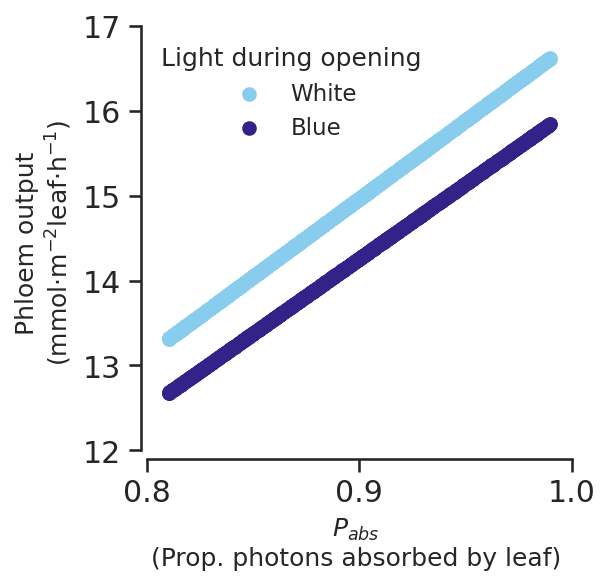

In [27]:
def phloemoutput_subfig(ax):
    for light, colour in zip(
        ["white", "blue"], [sns.color_palette()[1], sns.color_palette()[0]]
    ):
        constraints_light_df = scan_constraints[scan_constraints.light == light]
        results_light_df = scan_results[scan_constraints.light == light]

        ax.scatter(
            constraints_light_df.P_abs,
            results_light_df.Phloem_tx_overall,
            label=light.capitalize(),
            color=colour,
        )

    ax.legend(title="Light during opening", loc="upper left")  # Set loc to "upper left"
    ax.set_xlabel("$P_{abs}$\n(Prop. photons absorbed by leaf)", size="medium")
    ax.set_ylabel(
        "Phloem output\n(mmol$\cdot$m$^{-2}$leaf$\cdot$h$^{-1}$)", size="medium"
    )

    ax.set_ylim(11.9, 17)
    ax.set_xlim(0.797, 1)
    ax.spines["left"].set_bounds(12, 17)
    ax.spines["bottom"].set_bounds(0.8, 1)
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    # ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_aspect(abs(1 - 0.8) / abs(17 - 12))

    return ax


fig, ax = plt.subplots()
phloemoutput_subfig(ax)

## 7b - What affects hexose export from the guard cell?

### Generate hexose export df

In [28]:
four_stage_GC_model = cobra.io.sbml.read_sbml_model(
    "../models/4_stage_GC.xml"
)  # read model

# get total flux across all phases
net_carbon_dict = {}
for metabolite in ["GLC", "FRU", "SUCROSE"]:
    net_metabolite = 0
    for i, phase_length in enumerate(get_phase_lengths(four_stage_GC_model)):
        phase_number = i + 1
        net_metabolite = (
            net_metabolite
            + scan_results.loc[:, f"{metabolite}_ae_gc_{phase_number}"] * phase_length
        )
    net_carbon_dict[metabolite] = net_metabolite
net_carbon_df = pd.DataFrame.from_dict(net_carbon_dict)

# correct for fact that sucrose is two hexoses
net_carbon = (
    net_carbon_df.GLC + net_carbon_df.FRU + net_carbon_df.SUCROSE * 2
) * -1  # mmol.m2-1
net_carbon = net_carbon * 10**-3  # moles.m2-1
carbon_per_gc = net_carbon / scan_constraints.N_gcs  # moles.gc-1
carbon_per_gc = carbon_per_gc * 10**15  # fmol.gc-1

No objective coefficients in model. Unclear what should be optimized


### Fit model to hexose export

In [29]:
response = carbon_per_gc
for features in [full_features, gc_features]:
    lm_1 = LinearRegression()
    lm_1.fit(features, response)
    pred = lm_1.predict(features)
    print("Mean squared error, MSE = %.2f" % mean_squared_error(response, pred))
    print("Coefficient of determination, r2 = %.2f" % r2_score(response, pred))

Mean squared error, MSE = 392.25
Coefficient of determination, r2 = 0.45
Mean squared error, MSE = 118.22
Coefficient of determination, r2 = 0.83


So hexose export can be better predicted using the gc features compared to all the features. Is this because it's hexose per gc?

In [30]:
response = net_carbon
for features in [full_features, gc_features]:
    lm_1 = LinearRegression()
    lm_1.fit(features, response)
    pred = lm_1.predict(features)
    print("Mean squared error, MSE = %.2f" % mean_squared_error(response, pred))
    print("Coefficient of determination, r2 = %.2f" % r2_score(response, pred))

Mean squared error, MSE = 0.00
Coefficient of determination, r2 = 0.52
Mean squared error, MSE = 0.00
Coefficient of determination, r2 = 1.00


Seems so, as we're confusing things by introducing the N_gcs division into the response

In [31]:
response = net_carbon
lm_1 = LinearRegression()
lm_1.fit(gc_features, response)
pred = lm_1.predict(gc_features)
lm_coefs = pd.DataFrame(lm_1.coef_, index=gc_features.columns).sort_values(by=0)
lm_coefs[abs(lm_coefs.loc[:, 0]) > 0.00001]

,0
light_blue,-1.381741e+08
light_white,-1.381741e+08
Os_open,-8.054295e+05
V_closed,-1.611919e-02
ATPase,1.462491e-04
Photons,2.354302e-04
V_open,6.360736e-03
Os_dif,8.054295e+05
Os_closed,8.054295e+05


Mainly different light colours as well as osmolarity. What if we correct for light colour?

### Create a reponse for total photons into the GC, irrespective of blue or white light

In [32]:
photon_influx = scan_results.loc[:, "Photon_tx_gc_3"]
photon_hours = scan_constraints.loc[:, "light"].apply(
    lambda x: 12 if x == "white" else 11.5
)
total_photons_per_day = photon_influx * photon_hours

In [33]:
response = net_carbon
features = np.array([total_photons_per_day]).T
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
pd.DataFrame(lm_1.coef_, index=["Photons per day"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.952128


,0
Photons per day,0.000019


In [34]:
response = net_carbon
features = np.array([total_photons_per_day, gc_features.Os_dif]).T
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
pd.DataFrame(lm_1.coef_, index=["Photons per day", "Os dif"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.997839


,0
Os dif,-0.000042
Photons per day,0.000020


Pretty good R2

In [35]:
response = net_carbon
features = np.array(gc_features.ATPase).reshape(-1, 1)
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
pd.DataFrame(lm_1.coef_, index=["ATPase"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.109253


,0
ATPase,0.001702


ATPase can't really predict hexose export, at least not by itself

<Axes: xlabel='Photons per day into GC\n(mmol$\\cdot$m$^{-2}\\cdot$d$^{-1}$)', ylabel='Net hexose export flux from GC\n(mmol$\\cdot$m$^{-2}\\cdot$h$^{-1}$)'>

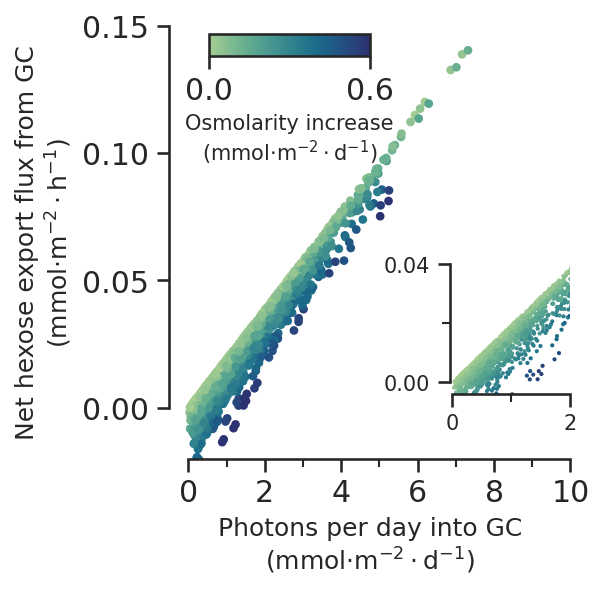

In [36]:
def photons_vs_carbon_export_subfig(ax):
    max_os_dif = scan_gc_constraints.Os_dif.max().round(1)
    norm = Normalize(vmin=0, vmax=max_os_dif)
    mappable = ScalarMappable(norm=norm, cmap=sns.color_palette("crest", as_cmap=True))

    net_carbon_mmol = net_carbon * 10**3

    ax.scatter(
        total_photons_per_day,
        net_carbon_mmol,
        c=scan_gc_constraints.Os_dif,
        norm=norm,
        s=10,
        cmap=sns.color_palette("crest", as_cmap=True),
    )

    cbaxes = ax.inset_axes([0.1, 0.93, 0.40, 0.05])
    cbar = plt.colorbar(
        mappable, cax=cbaxes, ticks=[0, max_os_dif], orientation="horizontal"
    )
    cbar.set_label("Osmolarity increase\n(mmol$\cdot$m$^{-2}\cdot$d$^{-1}$)", size=10)

    inset_ax = ax.inset_axes([0.7, 0.15, 0.3, 0.3])
    inset_ax.scatter(
        total_photons_per_day,
        net_carbon_mmol,
        c=scan_gc_constraints.Os_dif,
        s=1,
        cmap=sns.color_palette("crest", as_cmap=True),
    )
    inset_ax.set_xlim([-0.3 / 10, 2])
    inset_ax.set_ylim([-0.02 / 5, 0.04])
    inset_ax.tick_params(labelsize=10)
    inset_ax.spines["left"].set_bounds(0, 0.04)
    inset_ax.spines["bottom"].set_bounds(0, 2)
    inset_ax.yaxis.set_major_locator(MultipleLocator(0.04))
    inset_ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    inset_ax.xaxis.set_major_locator(MultipleLocator(2))
    inset_ax.xaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_xlim([-0.5, 10])
    ax.set_ylim([-0.02, 0.15])
    ax.spines["left"].set_bounds(0, 0.15)
    ax.spines["bottom"].set_bounds(0, 10)
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.set_aspect(abs(10 - 0) / abs(0.15 - 0))

    ax.set_xlabel(
        "Photons per day into GC\n" + r"(mmol$\cdot$m$^{-2}\cdot$d$^{-1}$)",
        size="medium",
    )
    ax.set_ylabel(
        "Net hexose export flux from GC\n" + r"(mmol$\cdot$m$^{-2}\cdot$h$^{-1}$)",
        size="medium",
    )

    return ax


fig, ax = plt.subplots()
photons_vs_carbon_export_subfig(ax)

### Are there any solutions where net carbon export are below 0?

In [37]:
(net_carbon < 0).sum()

177

In [38]:
(net_carbon > 0).sum()

1757

In [39]:
(net_carbon == 0).sum()

0

In [40]:
1-((net_carbon < 0).sum())/len(net_carbon)

0.9084798345398138

What's interesting about them?

In [41]:
scan_constraints.loc[net_carbon < 0]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
3,0.880998,0.000192,1.0,8.629192e-13,0.866582,0.051244,0.204472,0.309538,0.169957,0.813726,...,3.851195e+08,2.077401,0.940848,5.747590e-14,1.515328e-13,0.029770,3.399462,9.936390,12.606738,white
30,0.977490,0.000213,1.0,8.097892e-13,0.849340,0.085944,0.200220,0.228127,0.106448,0.830654,...,6.380687e+08,2.318837,0.830687,7.864234e-14,1.643929e-13,0.025288,3.333199,10.672109,11.311688,white
35,0.856504,0.000237,1.0,1.360312e-12,0.860652,0.067374,0.192203,0.258071,0.107286,0.777399,...,8.423951e+08,2.039681,0.993173,6.491681e-14,2.153582e-13,0.029056,3.839122,9.599664,13.331786,white
45,0.930783,0.000189,1.0,1.489148e-12,0.888709,0.046345,0.194218,0.231172,0.183409,0.831117,...,1.105337e+09,2.328963,0.866898,6.554262e-14,2.276119e-13,0.023463,3.689994,11.705067,7.102036,white
64,0.859688,0.000235,1.0,3.426082e-12,0.791894,0.052688,0.198979,0.230128,0.197351,0.842065,...,3.647771e+08,1.730236,0.919254,7.408027e-14,2.148666e-13,0.029782,1.697687,11.305181,13.115608,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882,0.845869,0.000172,1.0,1.048237e-12,0.845831,0.080705,0.199110,0.334855,0.163015,0.764383,...,2.061369e+08,1.615056,0.959637,7.543702e-14,2.598267e-13,0.027358,1.738303,9.792686,12.376386,blue
1910,0.891865,0.000236,1.0,1.587349e-12,0.841325,0.047596,0.190368,0.187888,0.114146,0.818767,...,8.062927e+08,1.649409,0.853218,7.850763e-14,2.357539e-13,0.024782,1.406129,6.738719,13.099119,blue
1917,0.917349,0.000172,1.0,6.231750e-13,0.847565,0.047245,0.195349,0.244040,0.192836,0.789315,...,9.777013e+08,1.535770,0.824097,5.226121e-14,2.318500e-13,0.024413,1.599696,9.447559,0.599285,blue
1918,0.979824,0.000215,1.0,7.663475e-13,0.834459,0.092777,0.203782,0.191754,0.104075,0.832115,...,2.886042e+08,2.043540,0.833630,5.487253e-14,1.306311e-13,0.031694,1.449804,8.414919,3.970192,blue


In [42]:
scan_gc_constraints.loc[net_carbon < 0]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
3,0.000134,0.000278,0.033181,0.140030,0.013079,0.004855,0.106849
30,0.000272,0.000640,0.063820,0.310722,0.027134,0.007218,0.246902
35,0.000391,0.000706,0.109738,0.371630,0.037644,0.011231,0.261892
45,0.000519,0.001100,0.133538,0.606216,0.055639,0.007850,0.472678
64,0.000124,0.000384,0.020705,0.204952,0.033219,0.004784,0.184247
...,...,...,...,...,...,...,...
1882,0.000081,0.000206,0.013085,0.098841,0.013994,0.002551,0.085757
1910,0.000279,0.000617,0.040490,0.207920,0.027690,0.010562,0.167430
1917,0.000308,0.000709,0.044057,0.291729,0.022555,0.000586,0.247672
1918,0.000061,0.000171,0.010122,0.069783,0.011858,0.001146,0.059661


Ok they are the same just with different light colours. Is it the photon/od_dif ratio?

In [43]:
scan_gc_constraints.loc[180, "Photons"] / scan_gc_constraints.loc[180, "Os_dif"]

0.8286998886406594

In [44]:
(scan_gc_constraints.loc[:, "Photons"] / scan_gc_constraints.loc[:, "Os_dif"]).min()

0.028310817388733575

Yes, it has the lowest photon:od_diff ratio of any combination

## At our predicted level of osmolarity and other guard cell parameters, what would FqFm.R_ch need to be for guard cell to act as a sink?

$e = FqFm \cdot R_{ch} \cdot R_{ch_{vol}}$ <- We want to know e, that is the capacity of guard cell vs mesophyll. Function of efficiency, number of chloroplasts, and valume of chloroplasts

$P_{gc} = e \cdot v\_prop_{gc} \cdot P$

$e = \frac{P_{gc}}{v\_prop_{gc} \cdot P}$

In [45]:
P = 150 * paper_constraints.P_abs
P = P * 10**-3 * 60 * 60  # umolessec-1 -> mmolhr-1

In [46]:
V_l = (
    paper_constraints.T_l * paper_constraints.A_l
)  # volume of leaf is area x thickness
V_l = V_l * 10**3  # (Total leaf volume) m3 -> dm3 = 10**3

V_gc = (
    paper_constraints.V_gc_ind * paper_constraints.N_gcs
)  # total volume of gc in leaf

# volume of meosphyll is leaf that isn't epidermis or air
V_me = V_l * (1 - paper_constraints.L_epidermis) * (1 - paper_constraints.L_air)

v_prop_gc = V_gc / V_me  # volume of gc is negligable

In [47]:
response = net_carbon
features = np.array([total_photons_per_day, gc_features.Os_dif]).T
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
print(f"Intercept: {lm_1.intercept_}")
pd.DataFrame(lm_1.coef_, index=["Photons per day", "Os dif"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.997839
Intercept: -2.9943170116709816e-07


,0
Os dif,-0.000042
Photons per day,0.000020


$ C_{net} = -3\cdot10^{-5}\cdot Os_{dif} + 2\cdot10^{-5}\cdot P_{day} - 6.80 \cdot10^{-8}$

$ 0 = -3\cdot10^{-5}\cdot 0.016 + 2\cdot10^{-5}\cdot P_{day} - 6.80 \cdot10^{-8}$

$ \frac{6.80 \cdot10^{-8}  + -3\cdot10^{-5}\cdot 0.016}{2\cdot10^{-5}} = P_{day}$

In [48]:
os_dif_coef = lm_1.coef_[1]
photons_per_day_coef = lm_1.coef_[0]
os_in_selected_scenarios = paper_gc_constraints.Os_dif
intercept = lm_1.intercept_

In [49]:
photons_needed = (
    intercept - os_dif_coef * os_in_selected_scenarios
) / photons_per_day_coef
photons_needed

0.01766160051488187

In [50]:
total_photons_per_day.min() / photons_needed

2.1088116678656323

So at that osmolarity for the guard cell to act as sink tissue the total level of photons coming in would have to be 15x lower than we see in any of our scenarios, which will be for blue light

In [51]:
photon_influx = photons_needed / 11.5

$e = \frac{P_{gc}}{v\_prop_{gc} \cdot P}$

In [52]:
e = photon_influx / (v_prop_gc * P)
e * 100

0.10441977210694658

So the capacity for photosynthesis in the guard cell only needs to be 0.1% of that of the mesophyll to act as a source tissue

### What is the range of photosynthetic capacities that we use?

In [53]:
capacity_percentages = (scan_constraints.FqFm * scan_constraints.R_ch) * 100
print(f"High: {capacity_percentages.max()}")
print(f"Low: {capacity_percentages.min()}")

High: 16.086936580407595
Low: 2.773358075436272


## 7c - So does the ATPase have an effect on starch if not on hexose export very much?

### How many solutions utilise starch?

In [54]:
starch = scan_results.STARCH_p_gc_Linker_1 - scan_results.STARCH_p_gc_Linker_2
print(f"{(starch > 0).sum()} or {(starch > 0).sum()/len(starch) * 100:.0f}%")

1892 or 98%


## In how many of those solutions is the ATPase constrained?

In [56]:
atpase_constrained = (
    abs(scan_gc_constraints.ATPase - scan_results.PROTON_ATPase_c_gc_2) < 0.000001
)
(atpase_constrained & starch > 0).sum()

1864

In [122]:
((scan_gc_constraints.ATPase - scan_results.PROTON_ATPase_c_gc_2) < 0.000001).sum() / (starch > 0).sum()

0.985200845665962

In [58]:
(starch <= 0).sum()

42

In [59]:
scan_gc_constraints[(atpase_constrained & (starch == 0))]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif


So there is one solution which doesn't

In [60]:
scan_gc_constraints[(atpase_constrained & starch < 0)]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif


In [61]:
#(scan_gc_constraints.loc[1685] - scan_gc_constraints.mean()) / scan_gc_constraints.std()

High photons, high ATPase, low osmolarity dif

## How many constrained solutions don't use starch?

In [62]:
(atpase_constrained & (starch == 0)).sum()

0

In [63]:
scan_gc_constraints[(atpase_constrained & (starch == 0))]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif


In [64]:
#(scan_gc_constraints.loc[1779] - scan_gc_constraints.mean()) / scan_gc_constraints.std()

Osmolarity difference is low, photons are high, atpase is low. Closed osmolarity is high, forcing the use of something else?

Increase per GC allows comparison with literature values

In [65]:
starch_per_gc = starch * 10**-3 / scan_constraints.N_gcs * 10**15  # fmol.gc-1

In [66]:
horrer_starch_level = 184

In [67]:
os_increase_per_gc = (
    scan_gc_constraints.Os_dif * 10**-3 / scan_constraints.N_gcs * 10**15
)
protons_moved_per_gc = (
    scan_results.PROTON_ATPase_c_gc_2 * 10**-3 / scan_constraints.N_gcs * 10**15
)

In [68]:
protons_moved_per_gc.max()

16.983568453252616

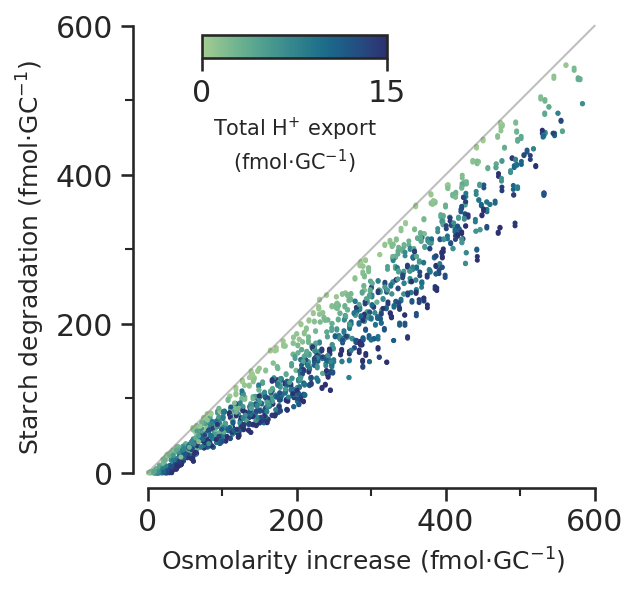

In [69]:
def starch_vs_os_subfig(ax):
    dot_size = 2

    norm = Normalize(vmin=0, vmax=15)
    mappable = ScalarMappable(norm=norm, cmap=sns.color_palette("crest", as_cmap=True))

    ax.plot([0, 600], [0, 600], c="grey", alpha=0.5, clip_on=False, linewidth=1)

    sc = ax.scatter(
        os_increase_per_gc,
        starch_per_gc,
        s=dot_size,
        c=protons_moved_per_gc,
        norm=norm,
        cmap=sns.color_palette("crest", as_cmap=True),
    )

    cbaxes = ax.inset_axes([0.15, 0.93, 0.40, 0.05])
    cbar = plt.colorbar(mappable, cax=cbaxes, ticks=[0, 15], orientation="horizontal")
    cbar.set_label("Total H$^{+}$ export\n(fmol$\cdot$GC$^{-1}$)", size=10)

    y_max = 600
    y_min = -20
    x_max = 600
    x_min = -20
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    ax.spines["left"].set_bounds(0, y_max)
    ax.spines["bottom"].set_bounds(0, x_max)
    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(200))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_aspect(1)

    ax.set_xlabel("Osmolarity increase (fmol$\cdot$GC$^{-1}$)", size="medium")
    ax.set_ylabel(r"Starch degradation (fmol$\cdot$GC$^{-1}$)", size="medium")
    # ax.hlines(-155, xmin=0.15, xmax=0.99, clip_on=False, linewidth=1, color='.15')

#     ax.hlines(
#         184,
#         xmin=0,
#         xmax=x_max,
#         linewidth=1,
#         linestyle="--",
#         color=sns.color_palette()[6],
#     )
#     ax.text(
#         x_max,
#         175,
#         "Horrer et al. (2016)",
#         ha="right",
#         va="top",
#         size="x-small",
#         color=sns.color_palette()[6],
#     )

#     paper_scenarios_colour = sns.color_palette()[2]
#     ax.vlines(
#         26.83,
#         ymin=0,
#         ymax=110,
#         linewidth=1,
#         linestyle="--",
#         color=paper_scenarios_colour,
#     )
#     ax.text(
#         50,
#         120,
#         "Paper\nscenarios",
#         ha="center",
#         va="bottom",
#         size="x-small",
#         color=paper_scenarios_colour,
#     )

    return ax


fig, ax = plt.subplots(figsize=(6, 4))

starch_vs_os_subfig(ax)

fig.savefig("../outputs/constraint_scan/atpase_vs_starch.svg")
fig.savefig("../outputs/constraint_scan/atpase_vs_starch.png")

### How do starch levels vary with white/blue light?

In [70]:
starch_per_gc

0       452.289024
1       277.547788
2         4.237398
3       167.427081
4        88.409571
           ...    
1931    401.554966
1932    111.326430
1933    269.642074
1934     81.257996
1935    271.281498
Length: 1934, dtype: float64

## How is starch used?

What proportion of white light solutions that degrade starch use it for osmoticum?

In [71]:
(
    (
        (scan_constraints["light"] == "white")
        & (starch > 0)
        & (scan_results.RXN_2141_p_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "white") & (starch > 0)).sum() * 100

100.0

What proportion of white light solutions that degrade starch use it for energy?

In [72]:
(
    (
        (scan_constraints["light"] == "white")
        & (starch > 0)
        & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "white") & (starch > 0)).sum() * 100

37.379162191192265

In the solutions that use it for energy, what is the average % used for energy?

In [73]:
(
    (
        (
            scan_results[
                (
                    (
                        (scan_constraints["light"] == "white")
                        & (starch > 0)
                        & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
                    )
                )
            ].MALTODEG_RXN_c_gc_2
        )
        / starch[
            (
                (scan_constraints["light"] == "white")
                & (starch > 0)
                & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
            )
        ]
    )
    * 100
).mean()

3.390568533696099

What proportion of blue light solutions that degrade starch use it for osmoticum?

In [74]:
(
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & (scan_results.RXN_2141_p_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "blue") & (starch > 0)).sum() * 100

96.98231009365244

In [75]:
((scan_constraints["light"] == "blue") & (starch > 0)).sum() - (
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & (scan_results.RXN_2141_p_gc_2 > 0)
    ).sum()
)

29

29 solutions doesn't

In [76]:
scan_constraints[
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & ~(scan_results.RXN_2141_p_gc_2 > 0)
    )
]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
1017,0.982189,0.000231,1.0,1.217851e-12,0.806859,0.073278,0.211816,0.312352,0.170798,0.850346,...,7.505322e+08,2.216148,0.988893,7.629564e-14,2.378212e-13,0.036241,3.213625,3.269583,5.188912,blue
1029,0.987023,0.000221,1.0,1.629365e-12,0.838141,0.096801,0.204151,0.251819,0.217884,0.765830,...,3.634520e+08,1.950142,0.846086,7.725629e-14,1.043478e-13,0.028292,2.862462,3.198156,13.387886,blue
1056,0.833108,0.000195,1.0,1.641114e-12,0.848315,0.162755,0.206171,0.278300,0.189228,0.863030,...,4.977284e+08,1.533894,0.896850,7.795038e-14,1.909829e-13,0.034884,3.554507,3.763593,14.205187,blue
1101,0.986662,0.000234,1.0,4.080272e-12,0.833938,0.038088,0.195959,0.208027,0.195915,0.851504,...,1.080920e+09,2.176108,0.871806,6.374026e-14,1.607315e-13,0.031215,2.021054,2.957040,13.642663,blue
1175,0.845082,0.000195,1.0,3.099346e-12,0.858672,0.105619,0.192160,0.271365,0.122900,0.805677,...,1.156622e+09,1.676400,0.938192,7.393047e-14,1.742883e-13,0.034981,3.772808,3.898576,11.481076,blue
1210,0.979145,0.000175,1.0,5.704240e-13,0.888548,0.072428,0.191789,0.325010,0.203983,0.860514,...,1.036523e+09,1.899936,0.859060,5.463702e-14,1.576704e-13,0.028699,3.722164,4.071019,8.231288,blue
1241,0.964159,0.000240,1.0,3.888226e-12,0.849131,0.040710,0.202661,0.308670,0.218431,0.872428,...,3.693487e+08,2.243153,0.842068,6.859716e-14,2.559610e-13,0.035843,3.687364,3.924401,16.420545,blue
1249,0.936919,0.000209,1.0,1.257865e-12,0.826065,0.170801,0.201451,0.200907,0.221662,0.862510,...,2.768268e+08,1.579182,0.975663,7.358545e-14,2.629005e-13,0.034054,2.918035,3.666386,16.455016,blue
1271,0.894960,0.000226,1.0,2.625296e-12,0.794778,0.090898,0.192567,0.205657,0.192150,0.771838,...,5.185705e+08,1.732175,0.982479,5.191611e-14,2.078991e-13,0.033018,2.881912,3.278714,10.054394,blue
1347,0.937104,0.000226,1.0,2.073399e-12,0.877991,0.157195,0.191900,0.227209,0.225836,0.794047,...,2.618422e+08,1.733078,0.888186,5.059401e-14,2.003447e-13,0.023230,3.869395,4.290222,12.594885,blue


What proportion of blue light solutions that degrade starch use it for energy?

In [77]:
(
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "blue") & (starch > 0)).sum() * 100

95.52549427679502

In [78]:
(
    (scan_constraints["light"] == "blue")
    & (starch > 0)
    & ~(scan_results.MALTODEG_RXN_c_gc_2 > 0)
).sum()

43

43 solutions that use starch in blue light don't use the energy pathway

In [79]:
(
    (
        (
            scan_results[
                (
                    (scan_constraints["light"] == "blue")
                    & (starch > 0)
                    & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
                )
            ].MALTODEG_RXN_c_gc_2
        )
        / starch[
            (
                (scan_constraints["light"] == "blue")
                & (starch > 0)
                & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
            )
        ]
    )
    * 100
).mean()

6.917530468681961

Average of 6.9% of starch degraded was used for energy

## 7d - How does glucose increase during opening vary with starch, and why isn't it totally linear?

Is sucrose degaded in the cytoplasm in any solutions?

In [80]:
(scan_results[starch > 0]["RXN_1461_c_gc_2"] > 0).sum()

0

No

In [81]:
sucrose_degraded_v = scan_results[starch > 0]["RXN_1461_v_gc_2"] > 0.000001
no_sucrose_degraded_v = scan_results[starch > 0]["RXN_1461_v_gc_2"] < 0.000001
glucose_import_into_vacuole = (
    scan_results[starch > 0]["GLC_PROTON_rev_cv_gc_2"] > 0.000001
)
no_glucose_import_into_vacuole = (
    scan_results[starch > 0]["GLC_PROTON_rev_cv_gc_2"] < 0.000001
)

In [82]:
sucrose_deg_and_glc_import = sucrose_degraded_v & glucose_import_into_vacuole
sucrose_deg_no_glc_import = sucrose_degraded_v & no_glucose_import_into_vacuole
no_sucrose_deg_glc_import = no_sucrose_degraded_v & glucose_import_into_vacuole
no_sucrose_deg_no_glc_import = no_sucrose_degraded_v & no_glucose_import_into_vacuole

In [83]:
conditions = [
    sucrose_deg_and_glc_import,
    sucrose_deg_no_glc_import,
    no_sucrose_deg_glc_import,
    no_sucrose_deg_no_glc_import,
]
labels = ["+ S.d. + G.i.", "+ S.d - G.i.", "- S.d + G.i.", "- S.d - G.i."]

In [84]:
for condition, label in zip(conditions, labels):
    print(f"{label}:")
    print(
        f"Length: {(condition).sum()} ({((condition).sum()/len(scan_constraints[starch > 0]) * 100).round(1)}%)"
    )
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).median()
    print(f"Starch median % of osmolarity: {starch_proportion}")
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).mean()
    print(f"Starch mean % of osmolarity: {starch_proportion}")
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).max()
    print(f"Starch max % of osmolarity: {starch_proportion}")
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).min()
    print(f"Starch min % of osmolarity: {starch_proportion}")

+ S.d. + G.i.:
Length: 1719 (90.9%)
Starch median % of osmolarity: 70.715257356063
Starch mean % of osmolarity: 70.75171038643512
Starch max % of osmolarity: 100.98969258230284
Starch min % of osmolarity: 33.70678055197705
+ S.d - G.i.:
Length: 48 (2.5%)
Starch median % of osmolarity: 42.479873042042186
Starch mean % of osmolarity: 40.49996318207206
Starch max % of osmolarity: 71.26373430673459
Starch min % of osmolarity: 19.421223452295543
- S.d + G.i.:
Length: 12 (0.6%)
Starch median % of osmolarity: 27.90927615890679
Starch mean % of osmolarity: 38.969721275346025
Starch max % of osmolarity: 89.30464909167985
Starch min % of osmolarity: 17.245084430356243
- S.d - G.i.:
Length: 113 (6.0%)
Starch median % of osmolarity: 23.38726473224462
Starch mean % of osmolarity: 26.19498288079809
Starch max % of osmolarity: 88.4285135863311
Starch min % of osmolarity: 0.010864363645033069


In [85]:
glc_increase = (
    scan_results[starch > 0].GLC_total_pseudolinker_2
    - scan_results[starch > 0].GLC_total_pseudolinker_1
)
glc_increase_per_gc = glc_increase * 10**-3 / scan_constraints.N_gcs * 10**15

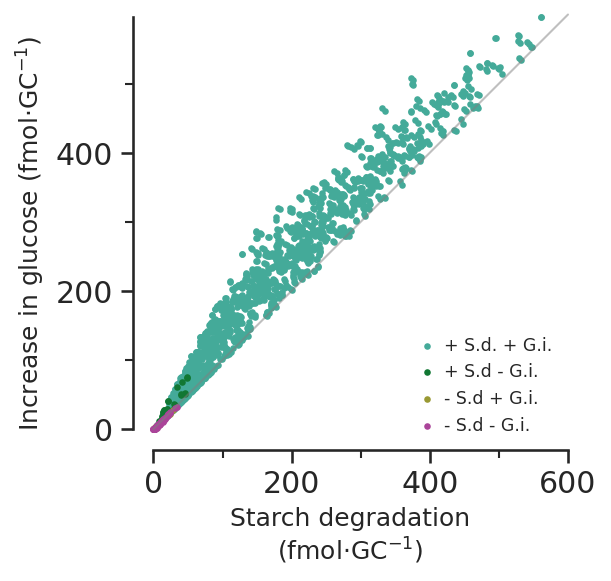

In [86]:
def glucose_vs_starch_subfig(ax):
    x = [0, 600]
    y = [0, 600]

    size = 10

    ax.plot(x, y, c="grey", alpha=0.5, clip_on=False, linewidth=1)

    conditions = [
        sucrose_deg_and_glc_import,
        sucrose_deg_no_glc_import,
        no_sucrose_deg_glc_import,
        no_sucrose_deg_no_glc_import,
    ]
    colours = [
        sns.color_palette()[2],
        sns.color_palette()[3],
        sns.color_palette()[4],
        sns.color_palette()[8],
    ]
    labels = ["+ S.d. + G.i.", "+ S.d - G.i.", "- S.d + G.i.", "- S.d - G.i."]

    glucose_increase_max = glc_increase_per_gc.max()

    for condition, colour, label in zip(conditions, colours, labels):
        ax.scatter(
            starch_per_gc[starch > 0][condition],
            glc_increase_per_gc[starch > 0][condition],
            color=colour,
            s=size,
            label=label,
            linewidths=0,
            clip_on=False,
        )

    ax.set_xlabel("Starch degradation\n" r"(fmol$\cdot$GC$^{-1}$)", size="medium")
    ax.set_ylabel("Increase in glucose (fmol$\cdot$GC$^{-1}$)", size="medium")

    y_max = glucose_increase_max
    x_max = 600
    major_increment = 200
    ax.set_ylim(None, y_max)
    ax.set_xlim(None, x_max)
    ax.spines["left"].set_bounds(0, y_max)
    ax.spines["bottom"].set_bounds(0, x_max)
    ax.xaxis.set_major_locator(MultipleLocator(major_increment))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(major_increment))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_aspect("equal")

#     ax.vlines(
#         184, ymin=0, ymax=570, linewidth=1, linestyle="--", color=sns.color_palette()[6]
#     )
#     ax.text(
#         184,
#         570,
#         "Horrer et al. (2016)",
#         ha="center",
#         va="bottom",
#         size="x-small",
#         color=sns.color_palette()[6],
#     )

    ax.legend(
        loc="lower right", bbox_to_anchor=(1, 0), handletextpad=0, fontsize="x-small"
    )

    return ax


fig, ax = plt.subplots()

glucose_vs_starch_subfig(ax)

fig.savefig("../outputs/constraint_scan/starch_vs_glucose.svg")
fig.savefig("../outputs/constraint_scan/starch_vs_glucose.png", dpi=300)

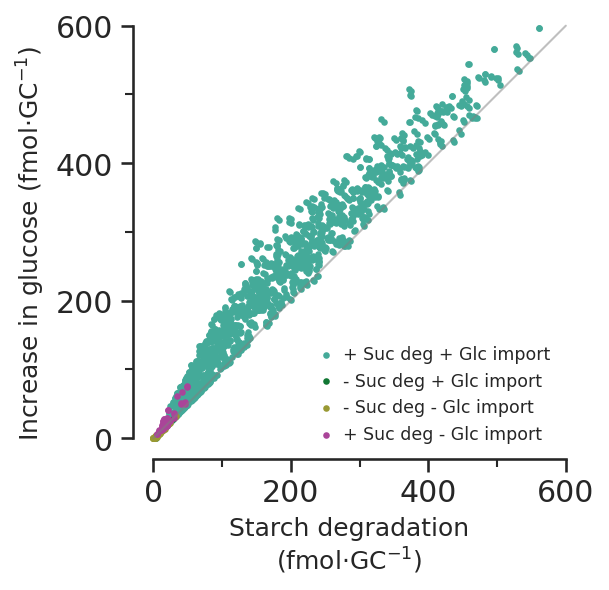

In [87]:
def glucose_vs_starch_subfig(ax):
    x = [0, 600]
    y = [0, 600]

    size = 10

    ax.plot(x, y, c="grey", alpha=0.5, clip_on=False, linewidth=1)

    conditions = [
        sucrose_deg_and_glc_import,
        no_sucrose_deg_glc_import,
        no_sucrose_deg_no_glc_import,
        sucrose_deg_no_glc_import,
    ]
    colours = [
        sns.color_palette()[2],
        sns.color_palette()[3],
        sns.color_palette()[4],
        sns.color_palette()[8],
    ]
    labels = ["+ Suc deg + Glc import", "- Suc deg + Glc import", "- Suc deg - Glc import", "+ Suc deg - Glc import"]

    glucose_increase_max = glc_increase_per_gc.max()

    for condition, colour, label in zip(conditions, colours, labels):
        ax.scatter(
            starch_per_gc[starch > 0][condition],
            glc_increase_per_gc[starch > 0][condition],
            color=colour,
            s=size,
            label=label,
            linewidths=0,
            clip_on=False,
        )

    ax.set_xlabel("Starch degradation\n" r"(fmol$\cdot$GC$^{-1}$)", size="medium")
    ax.set_ylabel("Increase in glucose (fmol$\cdot$GC$^{-1}$)", size="medium")

    #y_max = glucose_increase_max
    y_max = 600
    x_max = 600
    major_increment = 200
    ax.set_ylim(None, y_max)
    ax.set_xlim(None, x_max)
    ax.spines["left"].set_bounds(0, y_max)
    ax.spines["bottom"].set_bounds(0, x_max)
    ax.xaxis.set_major_locator(MultipleLocator(major_increment))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(major_increment))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_aspect("equal")

#     ax.vlines(
#         184, ymin=0, ymax=570, linewidth=1, linestyle="--", color=sns.color_palette()[6]
#     )
#     ax.text(
#         184,
#         570,
#         "Horrer et al. (2016)",
#         ha="center",
#         va="bottom",
#         size="x-small",
#         color=sns.color_palette()[6],
#     )

    ax.legend(
        loc="lower right", bbox_to_anchor=(1, 0), handletextpad=0, fontsize='x-small'
        #prop={'family': 'DejaVu Sans Mono', 'size': 'x-small'},
    )

    return ax


fig, ax = plt.subplots()

glucose_vs_starch_subfig(ax)

fig.savefig("../outputs/constraint_scan/starch_vs_glucose.svg")
fig.savefig("../outputs/constraint_scan/starch_vs_glucose.png", dpi=300)

## Combine subfigures

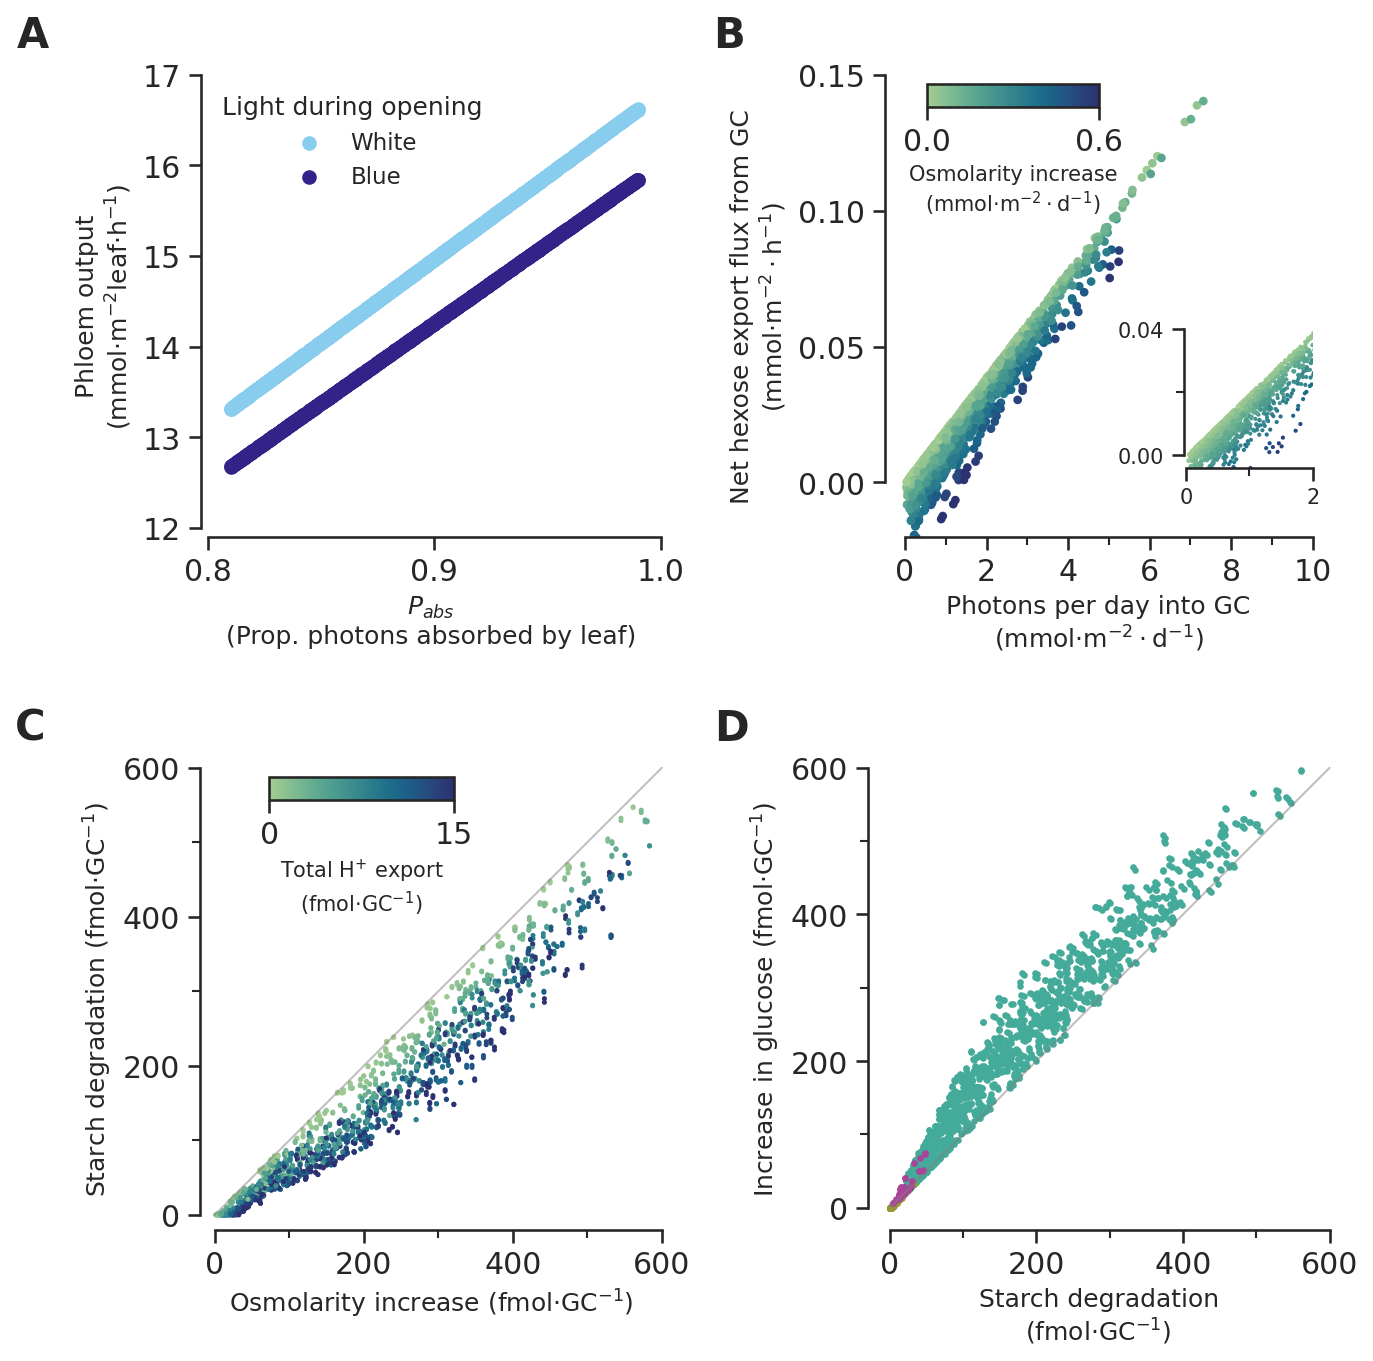

In [88]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plt.subplots_adjust(hspace=0.5, wspace=0.35)

phloemoutput_subfig(axs[0][0])

photons_vs_carbon_export_subfig(axs[0][1])

starch_vs_os_subfig(axs[1][0])

glucose_vs_starch_subfig(axs[1][1])
axs[1][1].get_legend().remove()

for ax, letter in zip(
    [axs[0][0], axs[0][1], axs[1][0], axs[1][1]], ["A", "B", "C", "D"]
):
    if letter != "D":
        ax.text(-0.4, 1.06, letter, transform=ax.transAxes, size=20, weight="bold")
    else:
        ax.text(-0.333, 1.06, letter, transform=ax.transAxes, size=20, weight="bold")

fig.savefig(
    "../outputs/constraint_scan/constraint_scan_analysis_plot.svg", transparent=True
)
fig.savefig(
    "../outputs/constraint_scan/constraint_scan_analysis_plot.png", transparent=True
)

------------

## Extra analyses not included

### What is the ratio of mitochondrial to plastidic ATP synthase?

Text(0.5, 0, 'Plastidial ATP Synthase\nMitochondrial ATP Synthase')

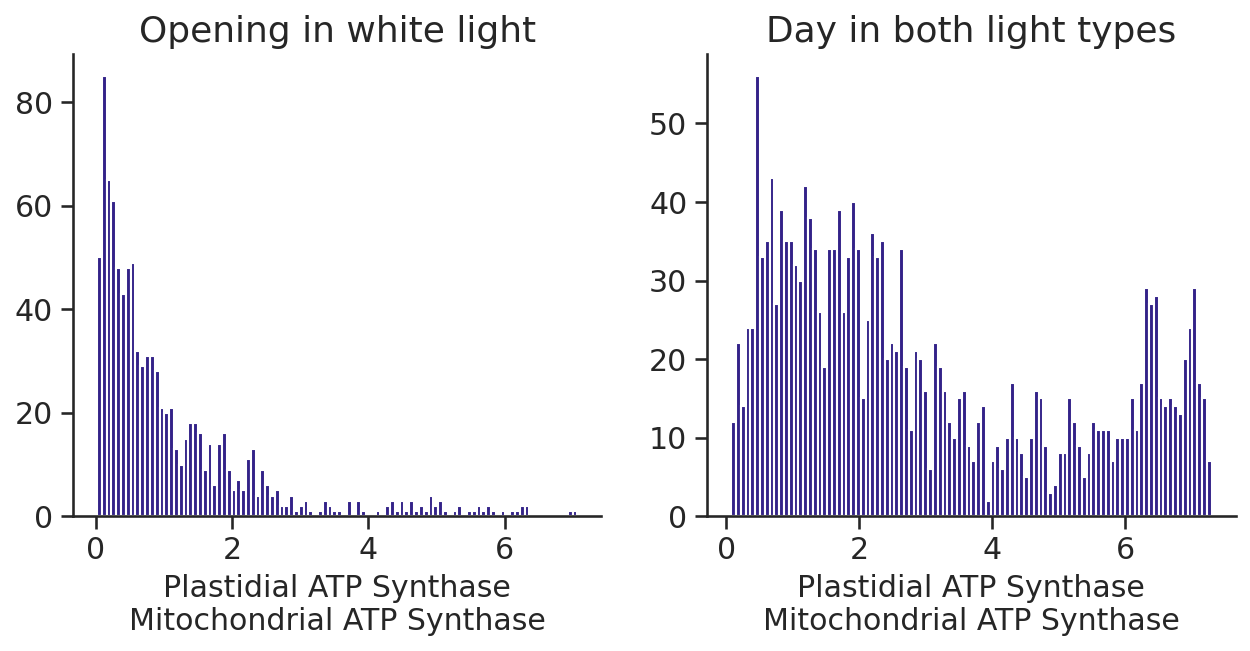

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(
    scan_results.Plastidial_ATP_Synthase_p_gc_2[scan_constraints.light == "white"]
    / scan_results.Mitochondrial_ATP_Synthase_m_gc_2[scan_constraints.light == "white"],
    bins=100,
)
axs[0].set_title("Opening in white light")
axs[0].set_xlabel("Plastidial ATP Synthase\nMitochondrial ATP Synthase")
axs[1].hist(
    scan_results.Plastidial_ATP_Synthase_p_gc_3
    / scan_results.Mitochondrial_ATP_Synthase_m_gc_3,
    bins=100,
)
axs[1].set_title("Day in both light types")
axs[1].set_xlabel("Plastidial ATP Synthase\nMitochondrial ATP Synthase")

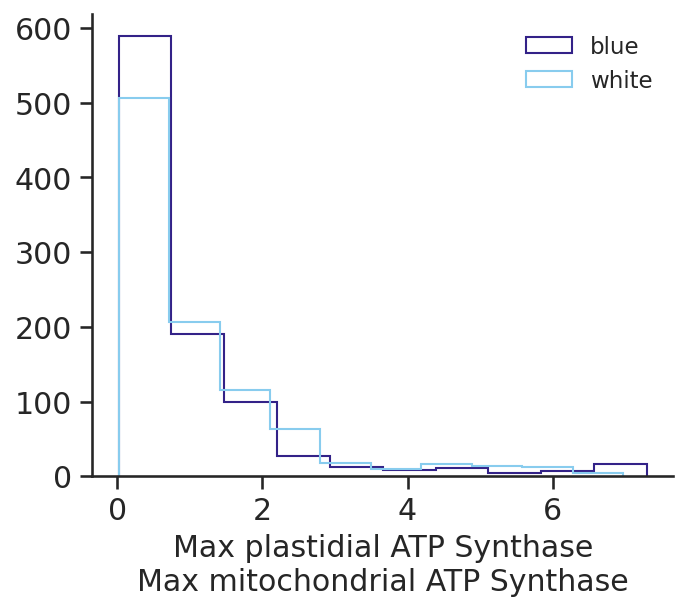

In [90]:
fig, ax = plt.subplots(1, figsize=(5, 4))

plastidial_atp_max = scan_results.loc[
    :, ["Plastidial_ATP_Synthase_p_gc_3", "Plastidial_ATP_Synthase_p_gc_2"]
].max(axis=1)
mitochondial_atp_max = scan_results.loc[
    :, ["Mitochondrial_ATP_Synthase_m_gc_3", "Mitochondrial_ATP_Synthase_m_gc_2"]
].max(axis=1)

for light in ["blue", "white"]:
    ax.hist(
        plastidial_atp_max[scan_constraints.light == light]
        / mitochondial_atp_max[scan_constraints.light == light],
        histtype="step",
        label=light,
    )

ax.set_xlabel("Max plastidial ATP Synthase\nMax mitochondrial ATP Synthase")

ax.legend()

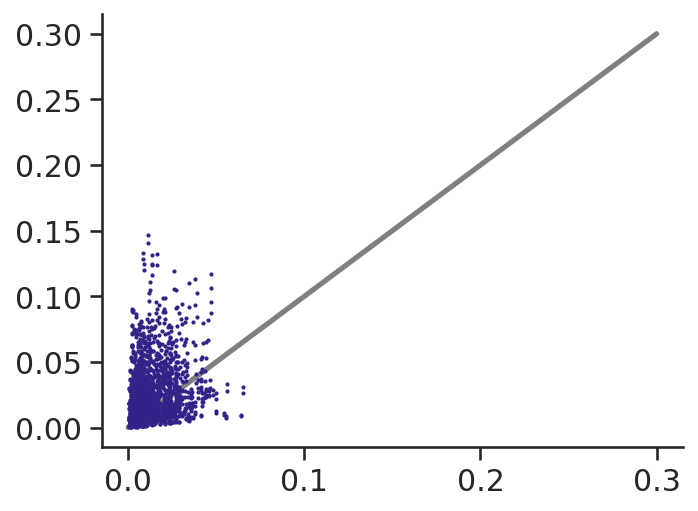

In [91]:
fig, ax = plt.subplots()

ax.plot([0, 0.3], [0, 0.3], c="grey", zorder=0)
ax.scatter(plastidial_atp_max, mitochondial_atp_max, s=1)

In [92]:
(plastidial_atp_max / mitochondial_atp_max).min()

0.016260605303926066

## Almost all starch is used for glucose, and PEP carboxykinase reaction never runs

In [93]:
(scan_results.PEPCARBOX_RXN_c_gc_2 > 0).sum()

77

In [94]:
(scan_results.PEPDEPHOS_RXN_c_gc_2 > 0).sum()

1237

In [95]:
((scan_results.MALTODEG_RXN_c_gc_2 > 0) & (scan_results.PEPDEPHOS_RXN_c_gc_2 > 0)).sum()

1227

In [96]:
((scan_results.MALTODEG_RXN_c_gc_2 > 0) & (scan_results.PYRUVDEH_RXN_m_gc_2 > 0)).sum()

1227

In [97]:
(
    (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    & (scan_results.ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc_2 > 0)
).sum()

1266

<Axes: >

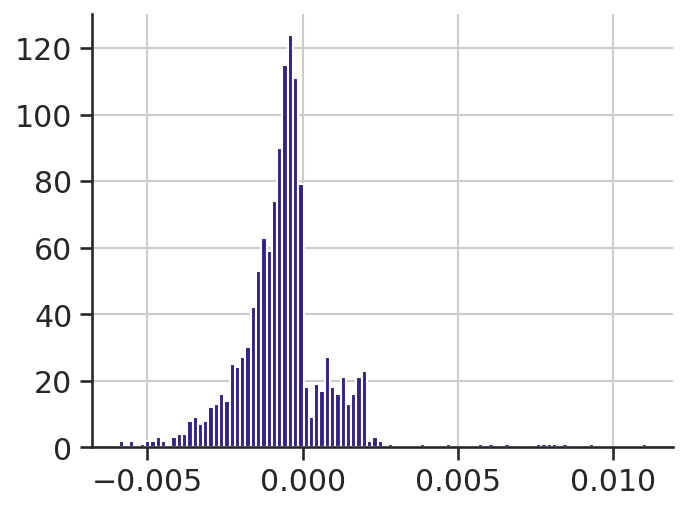

In [98]:
(
    scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].MALTODEG_RXN_c_gc_2 / 2
    - scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].PEPDEPHOS_RXN_c_gc_2
).hist(bins=100)

<Axes: >

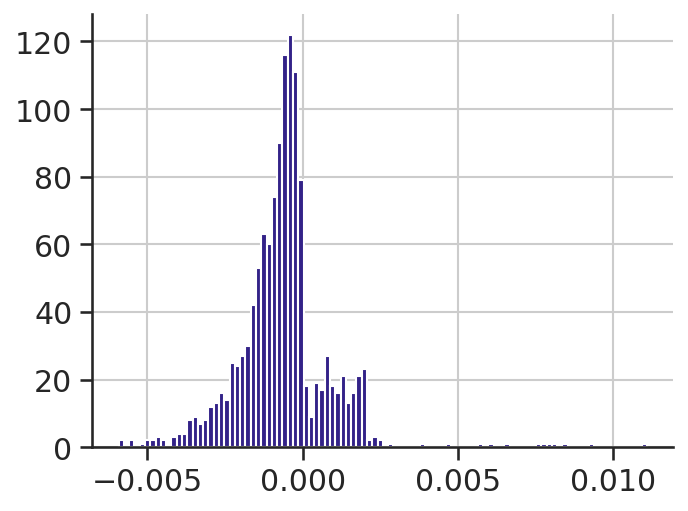

In [99]:
(
    scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].MALTODEG_RXN_c_gc_2 / 2
    - scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].PYRUVDEH_RXN_m_gc_2
).hist(bins=100)

In [100]:
(
    scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].MALTODEG_RXN_c_gc_2
    - scan_results[
        (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    ].ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc_2
)

0       0.001622
1       0.005446
3       0.001043
4       0.001028
6       0.006612
          ...   
1931    0.003674
1932    0.002604
1933    0.007325
1934    0.002005
1935    0.005452
Length: 1266, dtype: float64

In [101]:
(scan_results.MAL_total_pseudolinker_2 > 0).sum()

433

In [102]:
scan_constraints[
    (
        (scan_results.MAL_total_pseudolinker_2 - scan_results.MAL_total_pseudolinker_1)
        > 0
    )
]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
1,0.923180,0.000190,1.0,1.250880e-12,0.889162,0.093534,0.195869,0.337197,0.196606,0.837767,...,1.064044e+09,2.025073,0.946228,5.400144e-14,1.664063e-13,0.023524,2.500598,9.754649,0.549826,white
6,0.912552,0.000236,1.0,2.797833e-12,0.791717,0.122612,0.211564,0.203218,0.121087,0.788955,...,8.580407e+08,1.718809,0.985739,6.484944e-14,2.811758e-13,0.028334,1.156307,11.339261,2.620532,white
7,0.811951,0.000203,1.0,1.725438e-12,0.862305,0.134778,0.202345,0.342059,0.149051,0.886573,...,5.641395e+08,2.345712,0.922066,7.661761e-14,1.713217e-13,0.024734,3.836327,11.685743,0.807819,white
13,0.868580,0.000235,1.0,2.230336e-12,0.813387,0.143595,0.210389,0.231901,0.233709,0.788520,...,8.827028e+08,1.563814,0.955703,5.755866e-14,2.976694e-13,0.032311,2.576765,10.693166,4.401374,white
28,0.905738,0.000226,1.0,2.077161e-12,0.858599,0.065746,0.199877,0.232093,0.200455,0.892994,...,1.832267e+08,2.259343,0.879945,6.486503e-14,1.705626e-13,0.027999,2.573815,6.189742,0.199106,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,0.963328,0.000213,1.0,3.549447e-12,0.822882,0.088125,0.207902,0.284514,0.172490,0.882110,...,3.941232e+08,1.836419,0.800060,7.761785e-14,1.283119e-13,0.025384,3.250332,8.157482,5.580050,blue
1930,0.878002,0.000222,1.0,2.235053e-12,0.861774,0.132702,0.209615,0.209708,0.145820,0.865507,...,3.784323e+08,2.348202,0.814245,5.768938e-14,2.320267e-13,0.030561,2.664441,11.247607,3.675367,blue
1932,0.957473,0.000185,1.0,2.755496e-12,0.798181,0.097823,0.201847,0.193194,0.138359,0.823731,...,6.623405e+08,1.889247,0.969003,6.787495e-14,1.566538e-13,0.032169,1.321999,5.766979,2.750124,blue
1933,0.816118,0.000174,1.0,2.957736e-12,0.825422,0.149150,0.200244,0.323872,0.209562,0.830375,...,9.035571e+08,1.971395,0.971101,7.917051e-14,2.960270e-13,0.031594,1.293918,7.247967,1.492903,blue


In [103]:
#starch[1384]

In [104]:
#(scan_constraints.loc[1384] - scan_constraints.mean()) / scan_constraints.std()

In [105]:
#scan_constraints.loc[1384].ATPase

In [106]:
scan_constraints.mean().ATPase

/tmp/ipykernel_8731/856568451.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  scan_constraints.mean().ATPase


8.53114718372621

In [107]:
#atpase_constrained[1384]

In [108]:
#scan_results.loc[1384].MALTODEG_RXN_c_gc_2 / starch[1384] * 100

In [109]:
#scan_results.loc[1384].RXN_2141_p_gc_2

In [110]:
#scan_results.loc[1384].MALATE_DEH_RXN_m_gc_2

In [111]:
#scan_results.loc[1384].ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc_2

In [112]:
#(scan_gc_constraints.loc[1384] - scan_gc_constraints.mean()) / scan_gc_constraints.std()

In [113]:
for i in [i+1 for i in range(4)]:
    reaction = f"PALMITATE_c_gc_Linker_{i}"
    print(reaction)
    print(scan_results.loc[:, reaction].sum())

PALMITATE_c_gc_Linker_1
0.0
PALMITATE_c_gc_Linker_2
0.0
PALMITATE_c_gc_Linker_3
0.0
PALMITATE_c_gc_Linker_4
0.0


In [114]:
scan_results.filter(like="ATPase", axis=1)

,PROTON_ATPase_c_me_1,PROTON_ATPase_c_me_2,PROTON_ATPase_c_me_3,PROTON_ATPase_c_me_4,PROTON_ATPase_c_gc_1,PROTON_ATPase_c_gc_2,PROTON_ATPase_c_gc_3,PROTON_ATPase_c_gc_4,ATPase_tx_me_1,ATPase_tx_me_2,ATPase_tx_me_3,ATPase_tx_me_4,ATPase_tx_gc_1,ATPase_tx_gc_2,ATPase_tx_gc_3,ATPase_tx_gc_4
0,1.107532,3.646232,3.763789,1.104726,0.000025,0.004851,0.004851,0.000025,10.025916,12.182122,12.182122,10.025916,0.000444,0.000973,0.000973,0.000444
1,1.271757,4.186898,4.311376,1.268535,0.000057,0.000585,0.000585,0.000057,10.025916,12.468127,12.468127,10.025916,0.000444,0.000967,0.000967,0.000444
2,1.131079,3.723755,3.832643,1.128600,0.000000,0.004505,0.000000,0.000000,10.025916,12.223283,12.223283,10.025916,0.000444,0.000598,0.000598,0.000444
3,1.207758,3.976199,4.097909,1.204698,0.000583,0.004855,0.002277,0.000583,10.025916,12.356973,12.356973,10.025916,0.000444,0.000508,0.000508,0.000444
4,1.260299,4.149174,4.286096,1.257106,0.000025,0.011479,0.007823,0.000025,10.025916,12.448415,12.448415,10.025916,0.000444,0.000614,0.000614,0.000444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,1.105102,3.315307,3.773362,1.102419,0.000025,0.006605,0.006605,0.000025,10.025916,10.025916,12.273932,10.025916,0.000444,0.000444,0.001019,0.000444
1932,1.261907,3.785721,4.297397,1.258843,0.000057,0.001822,0.001822,0.000057,10.025916,10.025916,12.558822,10.025916,0.000444,0.000444,0.001011,0.000444
1933,1.056017,3.168052,3.599472,1.053454,0.000057,0.001349,0.001349,0.000057,10.025916,10.025916,12.183832,10.025916,0.000444,0.000444,0.001976,0.000444
1934,1.228512,3.685537,4.184889,1.225530,0.000025,0.003092,0.003092,0.000215,10.025916,10.025916,12.498539,10.025916,0.000444,0.000444,0.000641,0.000444


In [115]:
scan_constraints

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
0,0.815093,0.000194,1.0,2.262641e-12,0.809297,0.179970,0.191527,0.240879,0.214860,0.858645,...,4.484392e+08,1.933548,0.992641,7.886553e-14,1.678654e-13,0.033679,2.321339,11.318979,10.816668,white
1,0.923180,0.000190,1.0,1.250880e-12,0.889162,0.093534,0.195869,0.337197,0.196606,0.837767,...,1.064044e+09,2.025073,0.946228,5.400144e-14,1.664063e-13,0.023524,2.500598,9.754649,0.549826,white
2,0.830507,0.000220,1.0,5.035745e-13,0.821060,0.167889,0.204824,0.331556,0.205674,0.816618,...,5.758277e+08,2.141889,0.972835,6.579620e-14,2.457118e-13,0.034062,2.802180,3.338120,7.823891,white
3,0.880998,0.000192,1.0,8.629192e-13,0.866582,0.051244,0.204472,0.309538,0.169957,0.813726,...,3.851195e+08,2.077401,0.940848,5.747590e-14,1.515328e-13,0.029770,3.399462,9.936390,12.606738,white
4,0.915597,0.000220,1.0,7.391447e-13,0.846358,0.059969,0.193449,0.352066,0.238671,0.810491,...,1.046353e+09,2.396012,0.817798,7.654181e-14,1.652973e-13,0.028420,3.305233,7.650706,10.970481,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,0.849808,0.000174,1.0,2.640313e-12,0.880585,0.134355,0.193583,0.289995,0.213762,0.794641,...,4.117855e+08,1.711337,0.981658,6.898412e-14,1.062431e-13,0.033170,1.843784,11.521533,16.039577,blue
1932,0.957473,0.000185,1.0,2.755496e-12,0.798181,0.097823,0.201847,0.193194,0.138359,0.823731,...,6.623405e+08,1.889247,0.969003,6.787495e-14,1.566538e-13,0.032169,1.321999,5.766979,2.750124,blue
1933,0.816118,0.000174,1.0,2.957736e-12,0.825422,0.149150,0.200244,0.323872,0.209562,0.830375,...,9.035571e+08,1.971395,0.971101,7.917051e-14,2.960270e-13,0.031594,1.293918,7.247967,1.492903,blue
1934,0.934550,0.000234,1.0,1.122269e-12,0.799613,0.047919,0.202674,0.351210,0.192651,0.814861,...,1.121745e+09,2.313188,0.857276,6.322405e-14,1.450759e-13,0.023108,2.345988,6.138390,2.756515,blue


In [116]:
print(min(scan_constraints.P_abs))
print(min(scan_results.Phloem_tx_overall))

0.8101673308967071
12.675979574938289


In [117]:
print(max(scan_constraints.R_ch_vol))
print(min(scan_constraints.R_ch_vol))

0.2128525606703812
0.1889727321710271
